In [684]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot
import glob
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.figsize": (8, 8)})

In [1212]:
# %load label_copy.py
import scipy as sp
from scipy import ndimage
import pylab as pl
from skimage import filters


PLOT = False


def rebin(arr, new_shape):
    """Rebin 2D array arr to shape new_shape by averaging."""
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def getregion(img):

    tmp2 = rebin(img, (img.shape[0]/4, img.shape[1]/4))

    imgtmp = tmp2.copy()
    imgtmp[tmp2<np.mean(tmp2) + 2.*np.var(tmp2)]=0
    imgtmp[imgtmp>0]=1
    

    labels, n_features = ndimage.measurements.label(imgtmp)
    labelsize = np.array([(labels==i).sum() for i in range(labels.max()+1)])
    #labtmp = {}
    #for i in range(labels.max()+1):
    #    labtmp[i] = labelsize[i]

    #zeros = np.zeros_like(imgtmp.flatten())
    labs = np.unique(labelsize)
    labdiff = np.diff(np.unique(labelsize))
    
    print len(labs),",",np.max(labdiff[:-1]),',',(labdiff>=50).sum(),',',n_features,',', np.mean(labdiff[:-1]),',',np.max(labdiff)
    return len(labs),np.max(labdiff[:-1]),(labdiff>=50).sum(),n_features, np.mean(labdiff[:-1])
    #for i,z in enumerate(labels.flat):
    #    if (labtmp[z]>20) * (labtmp[z]<1000) : 
            #print (labtmp[z])
    #       zeros[i]=labtmp[z]

def read_and_plot(data_csv, plot = False):
    
    col_names = ['image', 'n_patches','2nd_largest_patch','patch_50+_pix','n_features','mean_patch_size', 'largest_patch']
    df = pd.read_csv(data_csv, header = None, names=col_names)
    df.loc[:,'image'] = np.array([int(l[12:16].strip().split()[0]) for l in df.loc[:,'image']])
    df.index = df.image
    df.drop('image', axis = 1, inplace = True)

    if plot:
        ax = df.plot(subplots = True,figsize = (8,8), title = str(data_csv))
        df.iloc[135:155,:].plot(subplots = True, ax = ax, color = 'k', legend = False)
        plt.savefig(str(data_csv) + '.pdf')
        plt.show()
    
    return df

#if __name__ == '__main__':
#   plot = PLOT
#   plumes = os.getenv('PLUMES_DATA')
#   imgpath =  os.path.join(plumes,'outputs/tmp_0*_median.npy')
#   tmp = np.sort(glob.glob(imgpath))

#   for t in tmp:
#      print t[68:],",",
#      try:
#         img = np.load(t)[200:1300,:,:].mean(-1)
#      except:
#         pass
            
#        getregion(img, plot=False)
        #if plot:
         #   pl.savefig(t.replace('median.npy','median_labels.pdf')\
                           #.replace('outputs','outputplots'))

        #pl.close(fig)
    


In [981]:
#import matplotlib.pyplot as plt
home = os.getenv('HOME') #Ilan's home directory
plumes = os.getenv('PLUMES') #plumes data
cuip = os.getenv('CUIP')

# Load the images

Once the images are loaded and saved into a text file they are ready to be plotted using the function read_and:plot as shown below for various cases.

In [ ]:
imgpath1 =  os.path.join(plumes,'outputs/tmp_*_median.npy')
#imgpath2 =  os.path.join(plumes,'outputs/tmp_01[345][0-9]_mindif.npy')

#print imgpath
imglist1 = sorted(glob.glob(imgpath1))
#imglist2 = sorted(glob.glob(imgpath2))
        
#print imglist
nimgs = len(imglist1)

#empty array to catch read images
#imgs = np.zeros((nimgs, 1300, 4096))
    
#imgs_min = np.zeros((nimgs, 1300, 4096))


for i,f in enumerate(imglist1):
    #print(f)
    imgs[i] = np.load(f)[200:1500,:,:].mean(-1)
    print f[68:],",",
    
    getregion(imgs[i])
    
#for i,f in enumerate(imglist2):
    #print(f)
    #imgs_min[i] = np.load(f)[200:1500,:,:].mean(-1)

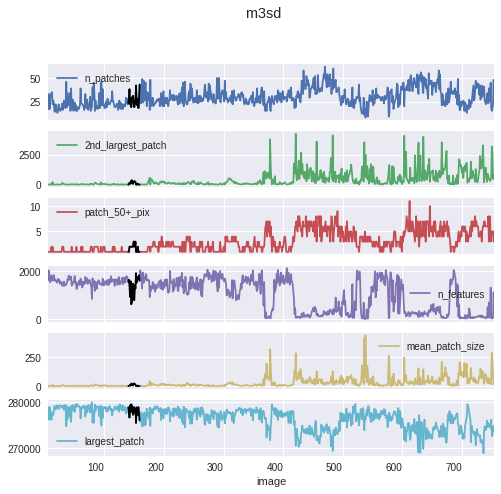

,n_patches,2nd_largest_patch,patch_50+_pix,n_features,mean_patch_size,largest_patch
image,,,,,,
5,25,4,1,1628,1.304348,278212
6,17,3,1,1678,1.200000,278897
7,33,14,1,2033,1.580645,276251
8,17,30,1,1622,4.133333,278947
9,27,24,1,1539,2.240000,278553
10,32,3,1,1621,1.266667,277141
11,34,55,2,1829,3.312500,276175
12,35,5,1,1680,1.484848,277111
13,22,229,2,1613,14.050000,277849


In [1213]:
read_and_plot('m3sd', plot = True)

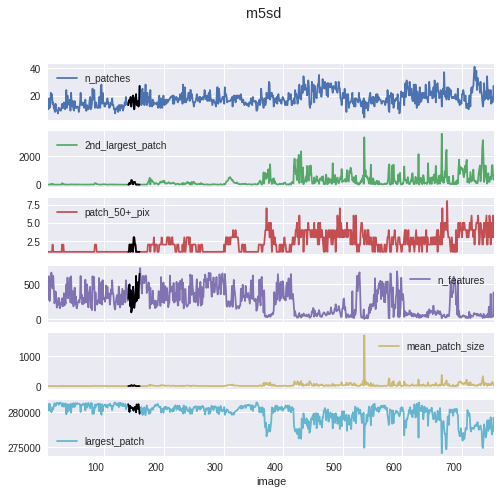

,n_patches,2nd_largest_patch,patch_50+_pix,n_features,mean_patch_size,largest_patch
image,,,,,,
5,15,3,1,417,1.307692,280774
6,10,9,1,286,2.000000,281121
7,18,10,1,612,2.187500,280189
8,11,4,1,258,1.444444,281166
9,12,26,1,393,3.700000,280832


In [1045]:
read_and_plot('m5sd', plot = True)

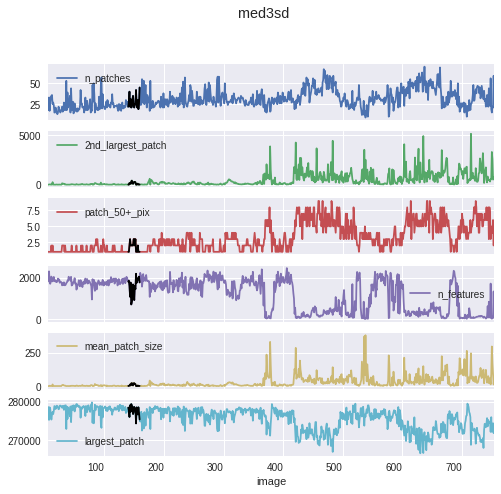

,n_patches,2nd_largest_patch,patch_50+_pix,n_features,mean_patch_size,largest_patch
image,,,,,,
5,28,7,1,1803,1.461538,277822
6,18,4,1,1863,1.312500,278611
7,33,14,1,2299,1.677419,275301
8,17,29,1,1867,4.266667,278553
9,26,22,1,1699,2.333333,278236
10,34,6,1,1791,1.406250,276627
11,35,50,2,2047,3.303030,275377
12,36,5,1,1854,1.441176,276624
13,25,256,2,1815,13.434783,277397


In [1243]:
read_and_plot('med3sd', plot = True)

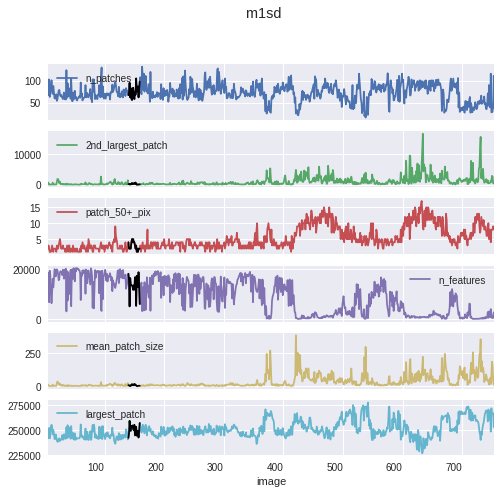

,n_patches,2nd_largest_patch,patch_50+_pix,n_features,mean_patch_size,largest_patch
image,,,,,,
5,74,804,2,15778,13.236111,245376
6,67,94,3,18549,5.138462,241879
7,103,303,2,6763,5.693069,252281
8,63,29,1,19351,2.672131,241881
9,69,24,1,17379,2.611940,245252
10,86,26,1,10877,2.595238,253326
11,101,56,2,6384,3.424242,255355
12,81,65,3,10784,3.708861,253172
13,70,675,2,16075,12.941176,245670


In [1242]:
read_and_plot('m1sd', plot = True)

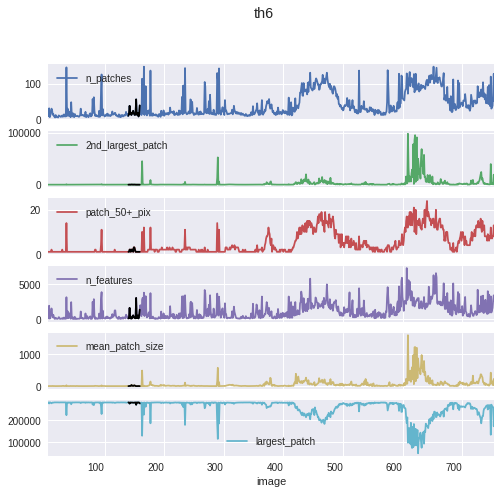

,n_patches,2nd_largest_patch,patch_50+_pix,n_features,mean_patch_size,largest_patch
image,,,,,,
5,13,2,1,300,1.090909,281029
6,9,7,1,119,1.857143,281390
7,31,12,1,1925,1.586207,276594
8,6,2,1,91,1.250000,281474
9,11,27,1,220,3.888889,281160
10,22,3,1,766,1.350000,279675
11,30,64,2,1539,3.607143,277322
12,25,13,1,804,1.869565,279578
13,13,41,1,280,6.636364,280979


In [1241]:
read_and_plot('th6', plot = True)

In [1238]:
df = read_and_plot('m5sd', plot = False)
final.head()

,smooth,smooth_std,unsmooth
image,,,
5,NaN,NaN,4
6,NaN,NaN,3
7,NaN,NaN,14
8,NaN,NaN,30
9,NaN,NaN,24


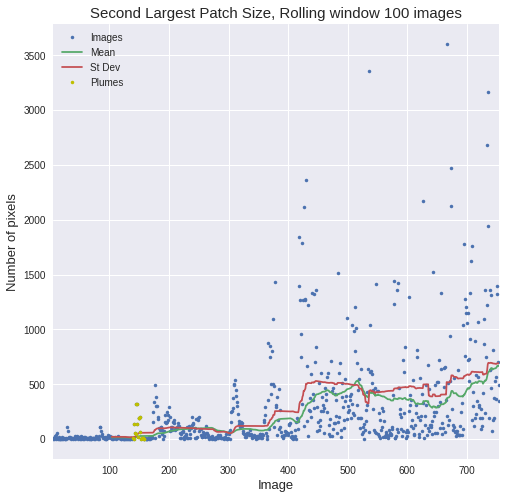

In [1239]:
unsmooth1 = df['2nd_largest_patch']

smooth1 = unsmooth1.rolling(window = 100, center = False, axis = 0).mean()
smooth1_sd = unsmooth1.rolling(window = 100, center = False, axis = 0).std()
final = pd.DataFrame({'unsmooth':unsmooth1, 'smooth':smooth1, 'smooth_std':smooth1_sd})
ax = final.unsmooth.plot(figsize = (8,8), linestyle = 'none', marker = '.')
final[['smooth', 'smooth_std']].plot(ax = ax)
final.unsmooth[135:155].plot(ax = ax, marker = '.', linestyle = 'none', c = 'y')

plt.title('Second Largest Patch Size, Rolling window 100 images', size = 15)
ax.legend(['Images', 'Mean','St Dev', 'Plumes'], loc = 2)
plt.ylabel('Number of pixels', size = 13)
plt.xlabel('Image', size = 13)
plt.savefig('rmean1_m5sd.pdf')

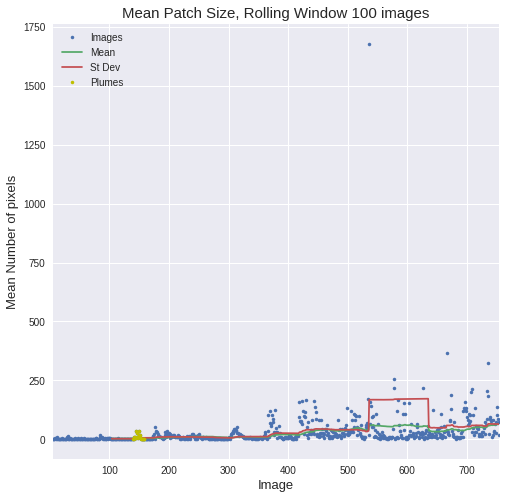

In [1240]:
unsmooth2 = df['mean_patch_size']
smooth2 = unsmooth2.rolling(window = 100, center = False, axis = 0).mean()
smooth2_std = unsmooth2.rolling(window = 100, center = False, axis = 0).std()
final2 = pd.DataFrame({'unsmooth':unsmooth2, 'smooth':smooth2, 'smooth_std':smooth2_std})
ax2 = final2.unsmooth.plot(figsize = (8,8), linestyle = 'none', marker = '.')
final2[['smooth', 'smooth_std']].plot(ax = ax2)
final2.unsmooth[135:155].plot(ax = ax2, marker = '.', linestyle = 'none', c = 'y')

plt.title('Mean Patch Size, Rolling Window 100 images', size = 15)
plt.ylabel('Mean Number of pixels', size = 13)
plt.xlabel('Image', size = 13)
plt.legend(['Images', 'Mean', 'St Dev', 'Plumes'], loc = 2)
plt.savefig('rmean2_m5sd.pdf')

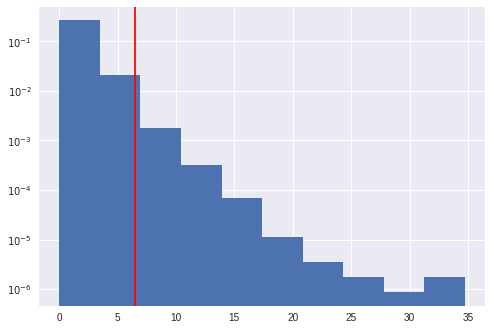

In [794]:
hist(tmp2.flatten(), normed = True, log = True)
axvline(np.mean(tmp2) + 4.*np.std(tmp2), c = 'r')

In [1034]:
#ls1 = tmp.iloc[0,135:155]
#ls2 = tmp.iloc[1,135:155]
#ls3 = tmp.iloc[2,135:155]
#ls4 = tmp.iloc[3,135:155]
#ls5 = tmp.iloc[4,135:155]
#ls6 = tmp.iloc[5,135:155]
    
#tmp_2 = [ls1,ls2,ls3,ls4,ls5,ls6]
#plumes = pd.DataFrame(tmp)
##plumes.head()

In [1033]:
#tmp2 = rebin(imgs[140], (imgs[139].shape[0]/4, imgs[139].shape[1]/4))

#imgtmp = tmp2.copy()


#imgtmp[tmp2<np.mean(tmp2) + 5.*np.std(tmp2)]=0
#imgtmp[imgtmp>0]=1

#labels, n_features = ndimage.measurements.label(imgtmp)

#labelsize = np.array([(labels==i).sum() for i in range(labels.max()+1)])

#labs = np.unique(labelsize)
#labdiff = np.diff(labs)

#print len(labs),",",np.max(labdiff),',',(labdiff>=50).sum(),',',n_features,',', np.mean(labdiff[:-1])

In [743]:
# filter the images based on log-histogram. 

#from skimage import color

#th = 10  #7, 10
#for i in range(nimgs):
    #img_filt[i][img_filt[i] < th] = 0.0
#    imgbw[i] = color.rgb2gray(img_tmp[i]) #set images to grayscale

In [28]:
#First plot of image with plume as example
#fig = figure(figsize = (13,11))
#imshow(imbin[140], cmap = 'viridis')
#axis('off')
#grid(False)

## Zoom into the different plumes and create histograms to see the behaviour

In [ ]:
#Zoom into the plume to see how well defined it is after filtering
#imshow(imgbw[1], cmap = 'viridis')

In [ ]:
#Histogram of the zoomed area
#hist(imgbw[12,800:900, 2000:2200].flatten(), log = True)
#hist(imgbw[12,810:865, 2000:2075].flatten(), alpha = 0.6)

In [ ]:
#imshow(imgbw[16,590:750, 1950:2050], cmap = 'viridis')

In [ ]:
#hist(imgbw[16,590:750, 1950:2050].flatten(), log = True)

In [ ]:
#imshow(img_filt[17,400:800, 1700:2200], cmap = 'viridis')

In [ ]:
#hist(img_filt[17,400:800, 1700:2200].flatten(), log = True)

In [ ]:
#imshow(img_filt[18,400:650, 2000:2300], cmap = 'viridis')

In [ ]:
#hist(img_filt[18,400:650, 2000:2300].flatten())

In [ ]:
#imshow(img_filt[19,200:600, 2000:2500], cmap = 'viridis')

In [ ]:
#hist(img_filt[19,200:600, 2000:2500].flatten(), log = True)

In [ ]:
#imshow(img_filt[20,200:500, 2300:2700], cmap = 'viridis')

In [ ]:
#hist(img_filt[20,200:500, 2300:2700].flatten(), log = True)

In [ ]:
#BINS = 50#int(round(2*len(img_med[0].flatten())**(1./3.)))
#y_md = np.zeros((nimgs, BINS))
#y_mn = np.zeros((nimgs, BINS))
#x = np.zeros(BINS)
#patches = np.zeros(BINS) #third element of histogram tuple NOT USED


#for i in range(nimgs):    
    #y_md[i], x, patches = plt.hist(img_tmp[i].flatten(), bins = BINS, log = True)
    #y_mn[i] = plt.hist(imgs_min[i].flatten(), bins = BINS, log = True)[0]

In [ ]:
#ymd_log = np.log10(y_md)

In [ ]:
#ymd_log[np.isinf(ymd_log)] = 0.0

In [ ]:
#bins_cen = x[:-1] + 0.5*(x[1]-x[0])

In [ ]:
#cols = ['img%d'%(i) for i in range(nimgs)]

#median_data = pd.DataFrame(ymd_log.T, columns = cols)
#median_data.insert(0, 'X', bins_cen)

## Histogram of oriented gradients

Documentation: http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html


In [27]:

#from skimage.feature import hog

#test, hogimg = hog(imgbw[15], orientations = 10, pixels_per_cell=(16, 16), 
 #                  cells_per_block=(4,4), visualise=True, block_norm='L1')

In [28]:
#figure(figsize = (12, 10))
#imshow(hogimg, cmap = 'viridis')
#grid(False)

In [29]:
#imshow(hogimg[580:780, 1800:2200], cmap = 'viridis')
#grid(False)

## Sobel filtering to detect edges of plumes

In [303]:
from skimage import filters
#edg1 = filters.sobel(imgbw[15])

In [31]:
#figure(figsize = (12, 10))
#imshow(edg1, cmap = 'viridis')
#grid(False)

In [32]:
#imshow(edg1[580:780, 1800:2200], cmap = 'viridis')

In [33]:
#hist(edg1.flatten(), log = True)

In [34]:
#edges = np.empty_like(imgbw)
#for i in range(nimgs):
#    edges[i] = filters.sobel(imgbw[i])


Making binary images based on filtering the brightness differences.

In [8]:
#label = np.zeros(nimgs)
#imbin = np.empty_like(imgbw)
#imvar = np.zeros(nimgs)
#for i in range(nimgs):
#    imbin[i] = np.where(imgbw[i] > 10, 1.0, 0.0)
#    imvar[i] = imbin[i].sum()
#    if imvar[i] > 1877 and imvar[i] < 40000:
#        label[i] = 1.
    #print i, imvar[i]

In [226]:
#figure(figsize = (12, 12))
#imshow(imbin[141], cmap = 'viridis')
#title('Block Image with plume', size = 14)
#axis('off')
#grid(False)


In [227]:
#label

In [221]:
#blk = np.zeros((nimgs, 50, 128))
#lbl = np.zeros(nimgs)
#for k in range(nimgs):
#    for i, x in enumerate(xrange(0,imbin[k].shape[0],26)):
#        for j, y in enumerate(xrange(0,imbin[k].shape[1],32)):
#            view = imbin[k,x:x+26, y:y+32]
#            blk[k,i,j] = np.where(view.sum() > 130, 1., 0.)
#            if blk[k].sum() >= 2. and blk[k].sum() < 30:
#                lbl[k] = 1.

In [133]:
#t = np.zeros(nimgs/10)
#v = np.empty_like(t)
#for i, j in enumerate(xrange(0, nimgs, 10)):
#    v[i] = imvar[j:j+10].var()
 #   t[i] = i

In [228]:
#t2 = np.arange(750)
#figure(figsize = (12, 8))
#plot(t2,imvar)
#plot(t2[137:149],imvar[137:149], color = 'r')
#xlabel('Image number', size = 15)
#ylabel('Number of Active Pixels (1s)', size = 15)
#title('Time series of active pixels', size = 18)
#legend(['no plume', 'plume'])

In [229]:

#figure(figsize = (12, 8))
#plot(t2,np.log10(imvar))
#plot(t2[137:148],np.log10(imvar[137:148]), color = 'r')
#xlabel('Image number', size = 15)
#ylabel('Log10 of Number of Active Pixels (1s)', size = 15)
#title('Time series of active pixels (Log Scale)', size = 18)
#legend(['no plume', 'plume'])

In [230]:
#figure(figsize = (10,8))
#plot(t,v)
#plot(t[13:16],v[13:16], color = 'r')
#xlabel('Image Group Number', size = 15)
#ylabel('Variance of Number of Active Pixels (1s)', size = 15)
#title('Time series of variance of active pixels', size = 18)
#legend(['no plume', 'plume'])

In [231]:
#figure(figsize = (10,8))
#plot(t,np.log10(v))
#plot(t[14:16],np.log10(v[14:16]), color = 'r')
#xlabel('Image Group Number', size = 15)
#ylabel('Log of Variance of Number of Active Pixels (1s)', size = 15)
#title('Time series of variance of active pixels (Log scale)', size = 18)
#legend(['no plume', 'plume'])